# 本次作业的任务是重现第一节课讲解的模型

## 问题1 CMSA网络的搭建

**你需要搭建一个基于LIF或ELIF神经元，拥有突触动力学的神经网络，通过调节一些参数，可以观察到整个网络中bump-wave模式的转变**

In [41]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float16)  # 由于LIF神经元相对比较简单，可以使用float16以节省显存
if torch.cuda.is_available():  # 优先使用gpu进行模拟
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'use device:{device}')
torch.set_grad_enabled(False) # 不使用自动梯度
torch.cuda.empty_cache() # 清空显存
dt = 0.5  # 模拟时间步长 ms
__t__ = 0  # 全局时间变量，用于计算不应期
spx_1=0
spy_1=0
k=0


use device:cuda


### Part1 LIF神经元层的搭建

首先我们定义LIF神经元的动力学：
$$
C\frac{dV}{dt}=-g_L*(V-V_{rest})+I_{input}
$$
其中的input包括外界的输入和突触输入。gL是神经元的漏电导。C是膜电容。

神经元的发放由下式定义：
$$
S=H(V-V_{threshold})*H(t-t_{spike}-\tau)
$$
其中的$\tau$是绝对不应期，发放后和在不应期中的膜电位会保持在V_rest

In [42]:
class LIFlayer:
    def __init__(self, n:int, threshold=-50.0, reset_value=-70.0, membrane_capacitance=1.0, gL=0.05, refractory_period=5):
        self.shape = (n,n)  # 网络形态
        self.threshold = threshold  # 发放阈值
        self.reset_value = reset_value  # 回复和静息电位，单位mV
        self.membrane_capacitance = membrane_capacitance  # 膜电容，单位nF
        self.gL = gL  # 漏电导，单位μS
        self.refractory = refractory_period  # 不应期，单位ms
        self.potential = torch.ones(self.shape).to(device) * (self.reset_value)  # 膜电位，单位mV
        self.spike = torch.zeros(self.shape).to(device)
        self.spike_time = torch.ones(self.shape).to(device) * (-self.refractory*5)  # 上一次的发放时间

    def update(self, input:torch.Tensor):
        assert input.shape == self.shape
        #Todu 请你完成膜电位、神经元发放和不应期的更新
        global __t__ ,dt
        global spy_1,spx_1,k
        
        #计算变化量
        dV_dt=(-self.gL*(self.potential-torch.full(self.shape,self.reset_value).to(device))+input)/self.membrane_capacitance
        #计算变化后的电位
        self.potential=self.potential+dV_dt*dt
        #是否spike
        self.spike = (self.potential > self.threshold).bool() * (__t__-self.spike_time-self.refractory>0).bool()  # 超过阈值且不在不应期内才发放 
        if self.spike.any() and k==0:  # 如果存在发放
            first_spike_idx = (self.spike == True).nonzero(as_tuple=False)[0]  # 获取第一个为 True 的位置
            k=1
            spy_1, spx_1 = first_spike_idx[0].item(), first_spike_idx[1].item()  # 转为 int 并赋值给全局变量
        
        #更新兴奋神经元的发放时间
        self.spike_time[self.spike]= __t__
        #将不应期的神经元设置为静息电位
        self.potential[(__t__-self.spike_time<self.refractory).bool()]=self.reset_value
        return self.potential, self.spike




In [43]:
'''
#test
lif_layer = LIFlayer(n=5, threshold=-50.0, reset_value=-70.0, membrane_capacitance=1.0, gL=0.05, refractory_period=5)

# 创建一个输入张量（5x5 的网络，模拟一个常数电流输入）
input_current = torch.ones(lif_layer.shape).to(device) * 10.0

for t in range(10): 
    potential, spike = lif_layer.update(input_current)
    
    print(f"Time step {t}:")
    print(f"Potential: \n{potential}")
    print(f"Spike: \n{spike}\n")
    
    # 如果神经元发放了脉冲，可以手动改变输入电流，看看反应
    if spike.sum() > 0:  # 如果有脉冲发放
        print(f"Spike detected at time step {t}")
        
        # 可修改输入电流，比如用一个零输入模拟不活跃状态
        input_current = torch.zeros(lif_layer.shape).to(device)  # 模拟无外部输入
'''

'\n#test\nlif_layer = LIFlayer(n=5, threshold=-50.0, reset_value=-70.0, membrane_capacitance=1.0, gL=0.05, refractory_period=5)\n\n# 创建一个输入张量（5x5 的网络，模拟一个常数电流输入）\ninput_current = torch.ones(lif_layer.shape).to(device) * 10.0\n\nfor t in range(10): \n    potential, spike = lif_layer.update(input_current)\n    \n    print(f"Time step {t}:")\n    print(f"Potential: \n{potential}")\n    print(f"Spike: \n{spike}\n")\n    \n    # 如果神经元发放了脉冲，可以手动改变输入电流，看看反应\n    if spike.sum() > 0:  # 如果有脉冲发放\n        print(f"Spike detected at time step {t}")\n        \n        # 可修改输入电流，比如用一个零输入模拟不活跃状态\n        input_current = torch.zeros(lif_layer.shape).to(device)  # 模拟无外部输入\n'

### Part2 突触层的搭建

AMPA和GABA统一使用指数衰减型突触（ExpSynapse），在这里模拟了突触电流和电导的过程，以及定义了高斯型波包。

$$
I = g*(Vrest-V)
$$
$$
\tau\frac{dg}{dt}=-g+W*S
$$

Pytorch中并没有自带的周期性边界条件。这里自行定义一个处理周期性边界条件的函数。通过scale_up和scale_down两个函数，实现了由I向E网络的缩放，这样可以在一个架构下处理两个不同尺寸的网络。

此外，请你定义连接权重的高斯波包：

$$
W_{ij}=W^{\lambda}e^{-\frac{(x_i-x_j)^2+(y_i-y_j)^2}{\sigma}}
$$

其中$W^{\lambda}$中${\lambda}$代表兴奋性或抑制性的输出，$\sigma$是衰减因子。

In [44]:

class Synapseslayer:
    def __init__(self, in_neuron:int, out_neuron:int, m_synapses:int, W=0.02, sigma=18, time_constant=3.0, Vrest = 0.0):
        '''m_synapse must be odd. because in the unfold function, if m is even, the index will shift'''
        self.in_neurons = in_neuron
        self.out_neurons = out_neuron
        assert out_neuron/in_neuron % 1 == 0 or in_neuron/out_neuron % 1 == 0  # 确保E_neurons和I_neurons的数量比是整数，以便于后续进行缩放

        self.shape = (out_neuron, out_neuron, m_synapses, m_synapses)
        self.time_constant = time_constant
        self.weight = self.gaussian(m_synapses, W, sigma)
        self.Vrest = Vrest

        self.i =  torch.zeros(self.shape).to(device)  # 突触电流，单位nA
        self.g = torch.zeros(self.shape).to(device)  # 突触电导，单位μS

    def gaussian(self, n, W, sigma):
        #Tosu 请你完成高斯波包函数，返回一个n*n矩阵，其中最大值位于正中间（n为奇数）
        # 计算中心点位置
        center = (n - 1) / 2
        # 生成坐标网格
        x = torch.arange(n, device=device)
        y = torch.arange(n, device=device)
        X, Y = torch.meshgrid(x, y, indexing='ij')  # 使用 'ij' 索引方式，确保行列顺序正确

        # 计算每个位置到中心点的平方距离
        distance_sq = (X - center) ** 2 + (Y - center) ** 2

        # 计算高斯波包矩阵
        gaussian = W * torch.exp(-distance_sq / sigma)
        '''
        print("W:",W)

        # 转换为 numpy 数组
        numpy_matrix = gaussian.clone().cpu().numpy()

        # 保存到文本文件
        np.savetxt(f'matrix{W}.txt', numpy_matrix, fmt='%.4f')
        '''
        return gaussian
    
    def update(self, input: torch.Tensor, potential:torch.Tensor):
        assert input.shape == (self.in_neurons, self.in_neurons)
        # change to matrix size to be adaptive
        if self.in_neurons<self.out_neurons:
            input = self.scale_up(input,self.out_neurons//self.in_neurons)
        else:
            input = self.scale_down(input,self.in_neurons//self.out_neurons)
        global dt ,__t__
        #Todu 请你完成突触电导和电流的更新（提示：使用torch.einsum计算input和weight的逐项乘积，使用repeat将单个神经元的膜电位展开成和突触张量同阶数的张量）
        #更新电导
        dg_dt=(-self.g + torch.einsum('abcd,cd->abcd',input, self.weight))/self.time_constant
        self.g=self.g+dt*dg_dt
        #展开膜电位并计算电流
        expanded_potential = potential.unsqueeze(2).unsqueeze(3).repeat(1, 1, self.shape[2], self.shape[3])
        self.i=self.g*(self.Vrest-expanded_potential)
        return self.i
        
    
    def scale_up(self, input:torch.Tensor, zoom_rate:int):
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2

        # 以下四个表达式完成了二维矩阵的扩展，以便后面进行平移展开操作
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        # 平移展开，得到每个突触对应神经元的spike情况
        input = input.unfold(0, self.shape[2], 1).unfold(1, self.shape[3], 1)

        # 将较小的synapselayer的相邻元素重复，得到较大的layer的输入
        input = input.repeat_interleave(zoom_rate,dim=0).repeat_interleave(zoom_rate,dim=1)
        return input
    
    def scale_down(self, input:torch.Tensor, zoom_rate:int): 
        # 和上面的同理
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        input = input.unfold(0, self.shape[2], zoom_rate).unfold(1, self.shape[3], zoom_rate)
        return input




 

### Part3 完成网络构建

将兴奋性神经元层和抑制性神经元层分别组合起来，并完成整个网络的更新

In [45]:
     
class Network:
    def __init__(self, En, In, rp, We, Wi) -> None:
        self.E_neurons = LIFlayer(n=En,refractory_period=rp)
        self.synapsesEE = Synapseslayer(En,En,101,W=We)
        self.synapsesEI = Synapseslayer(En,In,101,W=We)

        self.I_neurons = LIFlayer(n=In, refractory_period=rp)
        self.synapsesIE = Synapseslayer(In,En,101,Vrest=-80,sigma=400,W=Wi)
        self.synapsesII = Synapseslayer(In,In,101,Vrest=-80,sigma=400,W=Wi)

    def update(self, inputE:torch.Tensor, inputI:torch.Tensor):
        E_potential, E_spike = self.E_neurons.update(inputE+self.synapsesEE.i.sum(dim=(2,3))+self.synapsesIE.i.sum(dim=(2,3)))
        I_potential, I_spike = self.I_neurons.update(inputI+self.synapsesII.i.sum(dim=(2,3))+self.synapsesEI.i.sum(dim=(2,3)))
        self.synapsesEE.update(E_spike, E_potential)
        self.synapsesEI.update(E_spike, I_potential)
        self.synapsesIE.update(I_spike, E_potential)
        self.synapsesII.update(I_spike, I_potential)

        return E_potential,E_spike

### Part4运行模拟

模拟的更新方式已在上文定义。在模拟时，可以首先进行一段有输入的过程，然后撤去输入，观察网络的自发动力学。

最后输出模拟结束后的图像。最终结果需要看到bump, wave和critical state三种模式。

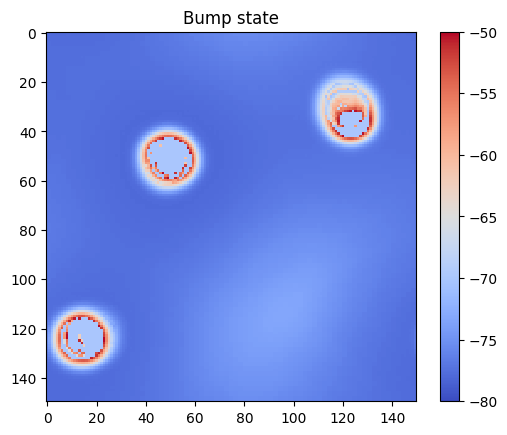
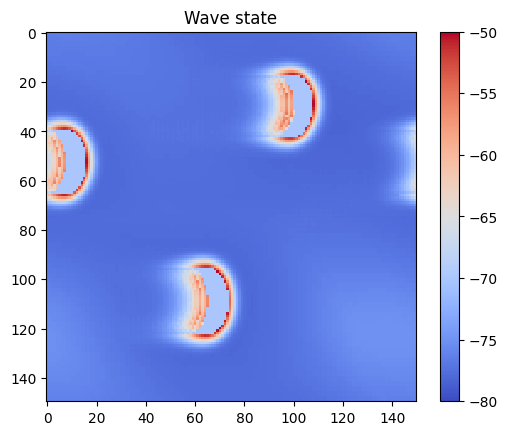
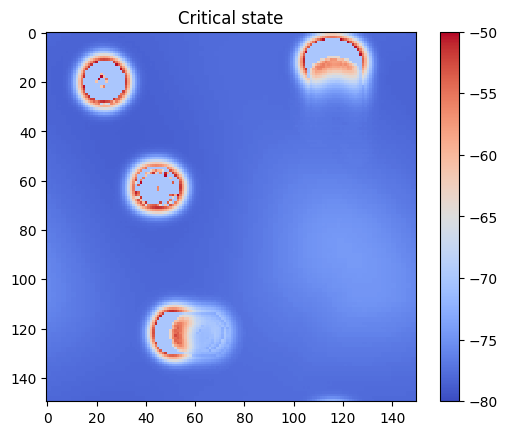

In [46]:
def draw_grah(We,Wi,rp,if_save=0,if_photo=0):
    print(f"Wi={Wi},We={We},rp={rp}")
    
    global __t__
    __t__=0
    En = 150 # 兴奋性神经元网格边长数，形成 10x10 的兴奋性神经元网格
    In = 75  # 抑制性神经元网格边长数，形成 5x5 的抑制性神经元网格
    runtime1 = 30  # 有外界输入的时间，单位为毫秒
    runtime = 200  # 自发动力学的时间，单位为毫秒
    #rp = 8  # 不应期时间，单位为毫秒
    #We = 0.16 # 兴奋性连接权重，控制兴奋性神经元之间的连接强度
    #Wi = 0.06  # 抑制性连接权重，控制抑制性神经元之间的连接强度
    net = Network(En,In,rp=rp,We=We,Wi=Wi)
    voltage_list = []

    for i in range(int(runtime1/dt)):
        __t__+=dt
        E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*5, torch.rand((In,In)).to(device)*5)  # 平均外界输入电流2.5nA
        voltage_list.append(E_potential.clone().cpu())

    for i in range(int(runtime/dt)):
        __t__+=dt
        E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*0, torch.rand((In,In)).to(device)*0)
        voltage_list.append(E_potential.clone().cpu())


    # 可以保存数据，使用Watch_Pattern.py观看动画
    V = np.array([v.numpy() for v in voltage_list])
    if(if_save):
        np.save(f'We={We}, Wi={Wi}, rp={rp}ms',V)
    if(if_photo):
        plt.imshow(E_potential.cpu(), cmap='coolwarm')
        plt.title(f'We={We}, Wi={Wi}, rp={rp}ms')
        plt.colorbar()
        plt.show()

        i=[30,55,50,65]
        j=30
        print(spx_1,spy_1)
        time_series_1 = [voltage[i[0], j] for voltage in voltage_list]
        time_series_2 = [voltage[i[1], j] for voltage in voltage_list]
        time_series_3 = [voltage[i[2], j] for voltage in voltage_list]
        time_series_4 = [voltage[i[3], j] for voltage in voltage_list]

        # Generate the time points based on dt
        time_points = [k * dt for k in range(len(voltage_list))]

        # Plot the time series for the selected (i, j) position
        plt.figure(figsize=(8, 6))
        plt.plot(time_points, time_series_1, label=f'Voltage at ({i[0]}, {j})',color="deepskyblue")
        plt.plot(time_points, time_series_2, label=f'Voltage at ({i[1]}, {j})',color="orange")
        plt.plot(time_points, time_series_3, label=f'Voltage at ({i[2]}, {j})',color="lawngreen")
        plt.plot(time_points, time_series_4, label=f'Voltage at ({i[3]}, {j})',color="lightcoral")

        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (mV)')  # Adjust this if necessary based on your data
        plt.title(f'Time Series of Voltage at Position ({i}, {j})')
        plt.legend()
        plt.show()
        
    return V

## 问题2 相变过程的探究

在本问题中，需要调整一个参数，模拟出整个相变过程，并通过定义一个序参量绘制相变曲线。序参量可以选择陈国璋老师课上讲过的方式，也可以自行定义。

### Part1 序参量的定义

序参量（Order Parameter）是物理里用于衡量相变系统有序程度的量。一般来说，序参量的变化是由对称性破缺引起的（定义来自Wikipedia）。

在这里，我们可以定义的常见序参量就是Pattern方向的一致性$\Phi$

$$
\Phi=\frac{\left\lvert \sum {\overrightarrow{v_i} }\right\rvert}{\sum {\overrightarrow{\left\lvert  v_i \right\rvert} }}
$$

下面请你完成$\Phi$的定义，并计算示例文件的$\Phi$，并结合不同斑图的状态解释这个序参量的物理含义的解释

In [47]:
data = np.load("Bump_example.npy")
#for i in range(data.shape[0]):
#    image = data[i]
#    centers = calcu_center(image)
image = data[0]  # 取第一个时间点的pattern

In [48]:
from scipy import ndimage
import matplotlib.pyplot as plt
from queue import Queue

dt = 0.5
runtime1 = 30  # 有外界输入的时间
runtime = 200  # 自发动力学的时间

def generate_search_directions(l):
    """
    生成l圈范围内的所有搜索方向坐标偏移量

    Parameters:
    l (int): 搜索范围圈数，l>=1

    Returns:
    list: 包含所有方向的坐标偏移量元组(di, dj)的列表
    """
    if l < 1:
        raise ValueError("l must be >= 1")

    directions = set()  # 使用集合避免重复方向

    # 遍历l圈范围内的所有可能坐标
    for i in range(-l, l+1):
        for j in range(-l, l+1):
            # 跳过(0,0)，因为这是中心点
            if i == 0 and j == 0:
                continue
            # 将坐标偏移加入方向集合
            directions.add((i, j))

    # 将集合转换为列表并返回
    return list(directions)

l = 7
neighbors = generate_search_directions(l)

def flood_fill_pattern(binary_data, start_pos, visited):
    """
    使用flood-fill算法识别一个pattern中的所有相连神经元

    Parameters:
    binary_data: 二值化的神经元活动数据(活跃为1，非活跃为0)
    start_pos: 起始位置(i, j)
    visited: 访问标记数组

    Returns:
    list: pattern中的所有神经元坐标
    """
    height, width = binary_data.shape
    pattern = []
    q = Queue()
    q.put(start_pos)

    # 8个方向的邻居坐标偏移
    #neighbors = generate_search_directions(l)

    while not q.empty():
        i, j = q.get()
        if visited[i,j]:
            continue

        visited[i,j] = True
        if binary_data[i,j] == 1:
            pattern.append((i,j))

            # 检查8个邻居
            for di, dj in neighbors:
                ni, nj = i + di, j + dj
                if (0 <= ni < height and 0 <= nj < width and
                    not visited[ni,nj] and
                    binary_data[ni,nj] == 1):
                    q.put((ni, nj))

    return pattern

def detect_patterns(data, threshold=-53) -> list:
    """
    使用flood-fill算法检测神经活动patterns

    Parameters:
    data: 神经元活动数据
    threshold: 定义活跃神经元的阈值

    Returns:
    list: 检测到的patterns列表
    """
    # 二值化数据
    binary = (data >= threshold).astype(int)
    height, width = binary.shape
    visited = np.zeros_like(binary, dtype=bool)
    patterns = []

    # 遍历所有神经元
    for i in range(height):
        for j in range(width):
            # 如果找到未访问的活跃神经元，开始flood fill
            if binary[i,j] == 1 and not visited[i,j]:
                pattern = flood_fill_pattern(binary, (i,j), visited)

                # 只保留大于最小大小的pattern
                if len(pattern) >= 5:  # 最小pattern大小，可调整
                    # 创建pattern掩码用于计算Euler特征
                    mask = np.zeros_like(binary)
                    for pi, pj in pattern:
                        mask[pi, pj] = 1

                    euler_number = calculate_euler_number(mask)
                    patterns.append({
                        'coords': pattern,
                        'type': 'crescent' if euler_number == 1 else 'patchy',
                        'euler': euler_number
                    })

    return patterns

def calculate_euler_number(mask): #这个先不算
    """
    计算mask的Euler特征
    """
    return 1

def calculate_centers(patterns) -> list:
    """
    计算每个pattern的质心位置（保持不变）
    """
    centers = []
    for pattern in patterns:
        coords = np.array(pattern['coords'])
        if len(coords) > 0:
            # 使用公式(5)计算质心
            IM = np.mean(coords[:, 0])
            JM = np.mean(coords[:, 1])
            centers.append({
                'center': (IM, JM),
                'type': pattern['type']
            })

    return centers

def calcu_center(image)->list:
    #image是包含多个斑图的二维数组
    #Todu 计算一个Pattern的中心位置，返回包含所有中心位置的列表。
    """
    计算一帧数据中所有pattern的中心位置
    """
    try:
        image = image.astype(np.float32)
        patterns = detect_patterns(image)
        centers = calculate_centers(patterns)

        # 提取center坐标
        center_coords = [(c['center'][0], c['center'][1]) for c in centers]

        #print(f"Detected {len(patterns)} patterns")
        #print(f"Calculated {len(centers)} centers")

        return center_coords

    except Exception as e:
        print(f"Error in pattern center detection: {str(e)}")
        return []

def visualize_centers(image, centers):
    """
    可视化检测到的中心位置
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='coolwarm')
    for center in centers:
        plt.plot(center[1], center[0], 'g+', markersize=10)  # 用绿色十字标记中心
    plt.colorbar()
    plt.title('Pattern Centers')
    plt.show()

from typing import List, Tuple, Dict
def calculate_centers_timeseries(data: np.ndarray) -> List[List[Tuple[float, float]]]:
    """
    计算时间序列上所有时间点的centers

    Parameters:
    data: 时间序列数据，shape为(time, height, width)

    Returns:
    List[List[Tuple[float, float]]]: 每个时间点的所有center坐标列表
    """
    centers_timeseries = []
    for t in range(data.shape[0]):
        centers = calcu_center(data[t])
        centers_timeseries.append(centers)
    return centers_timeseries

def match_patterns(prev_centers: List[Tuple[float, float]],
                  curr_centers: List[Tuple[float, float]],
                  max_distance: float = 20.0) -> List[Tuple[int, int]]:
    """
    匹配两个时间点之间的patterns

    Parameters:
    prev_centers: 前一个时间点的centers
    curr_centers: 当前时间点的centers
    max_distance: 最大匹配距离

    Returns:
    List[Tuple[int, int]]: 匹配的pattern索引对列表 (prev_idx, curr_idx)
    """
    matches = []
    used_curr = set()

    for i, prev_center in enumerate(prev_centers):
        min_dist = float('inf')
        best_match = -1

        for j, curr_center in enumerate(curr_centers):
            if j in used_curr:
                continue

            dist = np.sqrt((prev_center[0] - curr_center[0])**2 +
                          (prev_center[1] - curr_center[1])**2)

            if dist < min_dist and dist < max_distance:
                min_dist = dist
                best_match = j

        if best_match != -1:
            matches.append((i, best_match))
            used_curr.add(best_match)

    return matches

def calculate_velocities(centers_timeseries: List[List[Tuple[float, float]]],
                        dt,
                        max_distance: float = 10.0) -> List[List[np.ndarray]]:
    """
    计算所有pattern的速度

    Parameters:
    centers_timeseries: 时间序列上的centers
    dt: 时间步长
    max_distance: 最大匹配距离

    Returns:
    List[np.ndarray]: 速度向量列表
    """
    velocities_series = []

    for t in range(int(runtime1/dt), len(centers_timeseries) - 1):
        velocities = []
        prev_centers = centers_timeseries[t]
        curr_centers = centers_timeseries[t + 1]

        # 匹配patterns
        matches = match_patterns(prev_centers, curr_centers, max_distance)

        # 计算每对匹配pattern的速度
        for prev_idx, curr_idx in matches:
            prev_pos = np.array(prev_centers[prev_idx])
            curr_pos = np.array(curr_centers[curr_idx])
            velocity = (curr_pos - prev_pos) / dt
            velocities.append(velocity)
        if velocities != []:
          velocities_series.append(velocities)
        else:
          velocities_series.append([0])

    return velocities_series

def calcu_Phi(data: np.ndarray,
              #dt: float = 1.0,
              max_distance: float = 10.0) -> float:
    """
    计算pattern运动的一致性参数Phi

    Parameters:
    data: 时间序列数据
    dt: 时间步长
    max_distance: pattern匹配的最大距离

    Returns:
    float: Phi值 (0到1之间)
    """

    # 计算时间序列上的所有centers
    centers_timeseries = calculate_centers_timeseries(data)

    # 计算所有velocities
    #print(dt)
    velocities_series = calculate_velocities(centers_timeseries, dt, max_distance)

    if not velocities_series:
        print("No valid velocities calculated")
        return 0.0

    Phi_series = []
    # 转换为numpy数组便于计算
    #velocities = np.array(velocities)
    #print(velocities_series)
    for velocities in velocities_series:
      velocities = np.array(velocities)
      if len(velocities) > 1:
        vector_sum = np.sqrt(np.sum(np.sum(velocities, axis=0)**2))
        sum_magnitude = np.sum(np.sqrt(np.sum(velocities**2, axis=1)))
        Phi = vector_sum / sum_magnitude
      else:
        Phi = 1
      if sum_magnitude == 0:
          print(0.0)
      Phi_series.append(Phi)

    Phi = sum(Phi_series)/ len(Phi_series)
    ''' # 计算Phi
    sum_magnitude = np.sum(np.sqrt(np.sum(velocities**2, axis=1)))
    if sum_magnitude == 0:
        return 0.0

    vector_sum = np.sqrt(np.sum(np.sum(velocities, axis=0)**2))
    Phi = vector_sum / sum_magnitude '''

    return Phi

''' data = np.load("Critical_example.npy")
for i in range(data.shape[0]):
    image = data[i]
    centers = calcu_center(image)
image = data[10]  # 取第一个时间点的pattern
centers = calcu_center(image)
visualize_centers(image, centers) '''
'''
data = np.load("Bump_example.npy")
dt = 0.5
runtime1 = 30  # 有外界输入的时间
runtime = 200  # 自发动力学的时间
print(calcu_Phi(data))

data = np.load("Wave_example.npy")
print(calcu_Phi(data))
#data = np.load("Critical_example.npy")
#print(calcu_Phi(data))
'''

'\ndata = np.load("Bump_example.npy")\ndt = 0.5\nruntime1 = 30  # 有外界输入的时间\nruntime = 200  # 自发动力学的时间\nprint(calcu_Phi(data))\n\ndata = np.load("Wave_example.npy")\nprint(calcu_Phi(data))\n#data = np.load("Critical_example.npy")\n#print(calcu_Phi(data))\n'

### Part2 绘制序参量-外部条件的变化曲线

可以选取一个全局参数作为自变量（例如We/Wi、不应期时间等等），自行选择自变量范围和步长，绘制相变曲线，并对你的结果结合课上所学理论给出解释。

也鼓励大家尝试定义其他类型的序参量并进行测试。

Wi=0.06,We=0.12,rp=7.2


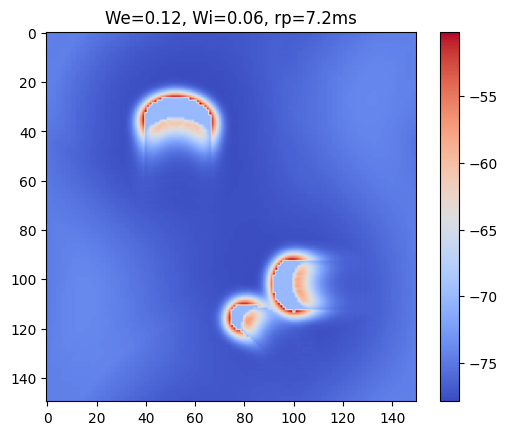

17 4


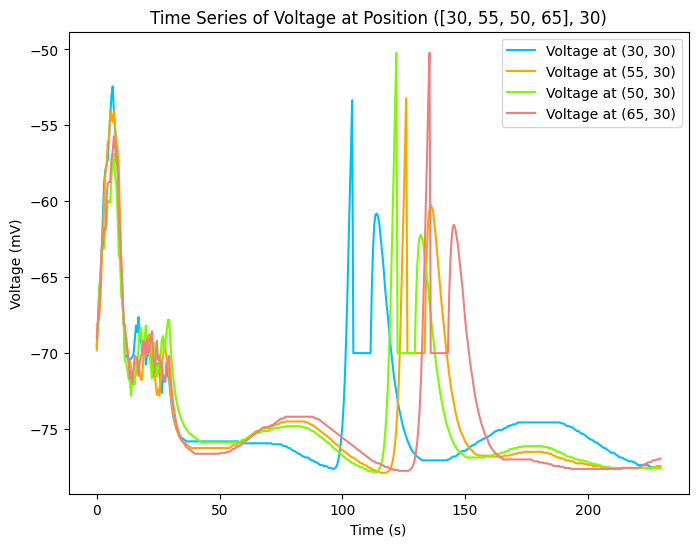

'\nphi=[]\nrp_list=[]\n\nstart_rp=60\nend_rp=70\n# phi change with refractory period\nfor rp in range(start_rp,end_rp,2):\n    rp_list.append(rp)\n    vot=draw_grah(0.18,0.06,rp/10)\n    phi.append(calcu_Phi(vot))\n    torch.cuda.empty_cache() # 清空显存\n\nnp.savetxt(\'phi_change_with_rp.txt\', phi)\n\n# 绘制变化曲线\nplt.figure(figsize=(8, 6))  # 设置图像大小\nplt.plot(rp_list, phi, marker=\'o\', linestyle=\'-\', color=\'b\', label=\'Phi vs Rp\')  # 曲线图\nplt.xlabel("Rp Value", fontsize=12)  # 设置横坐标标签\nplt.ylabel("Phi Value", fontsize=12)  # 设置纵坐标标签\nplt.title("Change of Phi with Rp", fontsize=14)  # 设置图像标题\n#plt.grid(True, linestyle=\'--\', alpha=0.7)  # 添加网格线\nplt.legend(fontsize=12)  # 添加图例\nplt.savefig(\'phi_vs_rp_curve.png\', dpi=300)  # 保存为高分辨率图片\nplt.show()  \n\n\nphi=[]\npro_ran=[]\n# phi change with proportion of We and Wi\nmin_pro=20#1.0\nmax_pro=30#\n\nfor We_Wi in range(min_pro,max_pro,2):# A proportion of We/Wi\n    pro_ran.append(We_Wi)\n    vot=draw_grah(0.06*We_Wi/10,0.06,6)\n    phi.

In [ ]:
torch.cuda.empty_cache() # 清空显存

def test_only_load_watch_file(Wi,prop,rp):
    We=Wi*prop
    draw_grah(We,Wi,rp,1,1)

#test_only_load_watch_file(Wi=0.06,prop=2,rp=7.2)

phi=[]
rp_list=[]

start_rp=50
end_rp=90
# phi change with refractory period
for rp in range(start_rp,end_rp,2):
    rp_list.append(rp)
    vot=draw_grah(0.18,0.06,rp/10)
    phi.append(calcu_Phi(vot))
    torch.cuda.empty_cache() # 清空显存

np.savetxt('phi_change_with_rp.txt', phi)

# 绘制变化曲线
plt.figure(figsize=(8, 6))  # 设置图像大小
plt.plot(rp_list, phi, marker='o', linestyle='-', color='b', label='Phi vs Rp')  # 曲线图
plt.xlabel("Rp Value", fontsize=12)  # 设置横坐标标签
plt.ylabel("Phi Value", fontsize=12)  # 设置纵坐标标签
plt.title("Change of Phi with Rp", fontsize=14)  # 设置图像标题
#plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线
plt.legend(fontsize=12)  # 添加图例
plt.savefig('phi_vs_rp_curve.png', dpi=300)  # 保存为高分辨率图片
plt.show()  


phi=[]
pro_ran=[]
# phi change with proportion of We and Wi
min_pro=12#1.0
max_pro=36#

for We_Wi in range(min_pro,max_pro,2):# A proportion of We/Wi
    pro_ran.append(We_Wi)
    vot=draw_grah(0.06*We_Wi/10,0.06,6)
    phi.append(calcu_Phi(vot))
    torch.cuda.empty_cache() # 清空显存

np.savetxt('phi_change_with_We_Wi.txt', phi)

# 绘制变化曲线
plt.figure(figsize=(8, 6))  # 设置图像大小
plt.plot(pro_ran, phi, marker='o', linestyle='-', color='b', label='Phi vs Proportion')  # 曲线图
plt.xlabel("Proportion", fontsize=12)  # 设置横坐标标签
plt.ylabel("Phi Value", fontsize=12)  # 设置纵坐标标签
plt.title("Change of Phi with We_Wi", fontsize=14)  # 设置图像标题
#plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线
plt.legend(fontsize=12)  # 添加图例
plt.savefig('phi_vs_We_Wi_curve.png', dpi=300)  # 保存为高分辨率图片
plt.show() 


### Part3附加题 临界态对注意力模式的影响

在不同状态下给定一个输入图案，探究Pattern聚焦到图案这一过程的特点。从而解释为什么说大脑应该处于临界态。

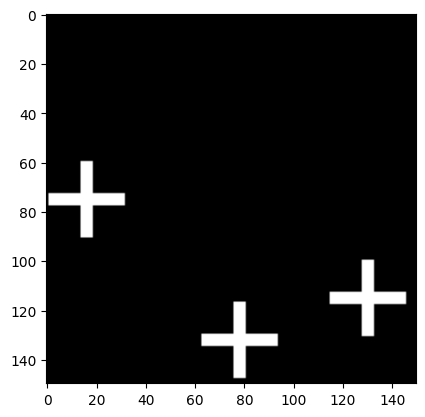

In [50]:
image = np.load('image_cross.npy')
plt.imshow(image,cmap='gray')
plt.show()

#Todu 将image作为输入


## 问题3 更加复杂模型下的动力学性质

**本问题是一个开放性问题，不要求在本次完成。希望学有余力的同学提前思考一下，可以作为最后一次大作业的Discussion**

要求：围绕大脑中的临界态和相变现象研究一个课题，以下给出几个方向可供参考

1.多层动力学网络：考虑多个上述网络的耦合

2.考虑不同种类的抑制性神经元：抑制性神经元（又称中间神经元，interneuron），常见的有PV、SsT、VIP等，可以考虑引入这些神经元观察其对网络动力学特性的影响

3.大脑中其他类型的临界态探究

4.考虑一些学习过程（如LTP等），观察对临界态状态的影响